In [1]:
import torch
import torch.nn as nn
import os
from torch import optim
from model import VisionTransformer
from utils_vit import get_loader
from tqdm import tqdm
import contextlib
import datetime


In [2]:
device = torch.device("mps")


train_loader, test_loader = get_loader()
model = VisionTransformer16().to(device)
ce = nn.CrossEntropyLoss()
    
def train_and_evaluate():
    optimizer = optim.AdamW(model.parameters(), 5e-4, weight_decay=1e-3)
    cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer, 200, verbose=True)
    total_step = len(train_loader)

    accuracies = []

    for epoch in range(200):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        model.train()
        for i, (images, labels) in pbar:
            with contextlib.redirect_stdout(open(os.devnull, "w")):
                optimizer.zero_grad()
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = ce(outputs, labels)
                loss.backward()
                optimizer.step()
                if (i + 1) % 200 == 0:
                    pbar.set_description(f'Epoch [{epoch + 1}/{200}], Step [{i + 1}/{total_step}], Loss: {loss.item()}')
                cos_decay.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            pbar_test = tqdm(test_loader)
            for images, labels in pbar_test:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar_test.set_description(f'Accuracy: {100 * correct / total:.2f}%')

            accuracy = 100 * correct / total
            accuracies.append(accuracy)
    return accuracies



In [3]:
start_time = datetime.datetime.now()
accuracies = train_and_evaluate()
end_time = datetime.datetime.now()

best_accuracy = max(accuracies)
print(f'Final accuracy: {best_accuracy:.2f}%')
print(f'Training time: {end_time - start_time}')

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch [1/200], Step [400/468], Loss: 0.8727325201034546: 100%|██████████| 468/468 [02:08<00:00,  3.64it/s]
Accuracy: 69.85%: 100%|██████████| 79/79 [00:09<00:00,  8.57it/s]
Epoch [2/200], Step [400/468], Loss: 0.7184591293334961: 100%|██████████| 468/468 [02:11<00:00,  3.57it/s]
Accuracy: 76.83%: 100%|██████████| 79/79 [00:09<00:00,  8.58it/s]
Epoch [3/200], Step [400/468], Loss: 0.6627159118652344: 100%|██████████| 468/468 [02:11<00:00,  3.56it/s]
Accuracy: 78.15%: 100%|██████████| 79/79 [00:08<00:00,  8.87it/s]
Epoch [4/200], Step [400/468], Loss: 0.5176981687545776: 100%|██████████| 468/468 [02:02<00:00,  3.83it/s]
Accuracy: 77.85%: 100%|██████████| 79/79 [00:08<00:00,  9.40it/s]
Epoch [5/200], Step [400/468], Loss: 0.4377620220184326: 100%|██████████| 468/468 [02:00<00:00,  3.90it/s]
Accuracy: 77.86%: 100%|██████████| 79/79 [00:08<00:00,  9.38it/s]
Epoch [6/200], Step [400/468], Loss: 0.5009666681289673: 100%|██████████| 468/468 [02:00<00:00,  3.89it/s] 
Accuracy: 78.74%: 100%|████

Final accuracy: 92.24%
Training time: 8:24:16.513640


[69.85, 76.83, 78.15, 77.85, 77.86, 78.74, 81.41, 83.06, 83.76, 83.33, 83.34, 82.63, 82.41, 85.28, 85.89, 85.8, 84.77, 84.19, 85.4, 86.85, 87.11, 87.03, 85.75, 85.54, 85.76, 87.65, 87.88, 87.58, 85.19, 86.74, 87.68, 88.02, 88.36, 87.98, 86.87, 87.17, 88.01, 88.62, 88.62, 87.99, 87.69, 87.23, 88.72, 88.97, 88.95, 88.8, 87.53, 88.15, 89.01, 89.19, 89.06, 88.99, 87.28, 87.84, 89.47, 89.57, 89.47, 88.81, 87.72, 89.04, 89.93, 89.76, 89.87, 89.39, 88.98, 89.15, 89.85, 89.84, 89.96, 88.89, 88.66, 89.78, 90.21, 90.08, 89.89, 88.74, 89.02, 89.77, 90.24, 90.65, 90.31, 88.6, 89.89, 89.75, 90.51, 90.8, 90.4, 89.19, 89.63, 90.44, 90.66, 90.91, 90.64, 90.39, 90.3, 90.37, 90.89, 90.87, 90.56, 90.21, 90.48, 90.54, 90.95, 90.94, 90.69, 90.4, 90.29, 90.69, 91.05, 91.09, 90.38, 90.09, 90.51, 91.17, 91.35, 91.5, 90.69, 90.18, 89.99, 91.19, 91.19, 91.06, 90.93, 90.31, 90.3, 91.37, 91.61, 91.26, 90.61, 90.02, 90.52, 91.37, 91.16, 90.86, 90.91, 90.65, 91.16, 91.41, 91.74, 91.25, 90.28, 90.91, 91.46, 91.52, 9

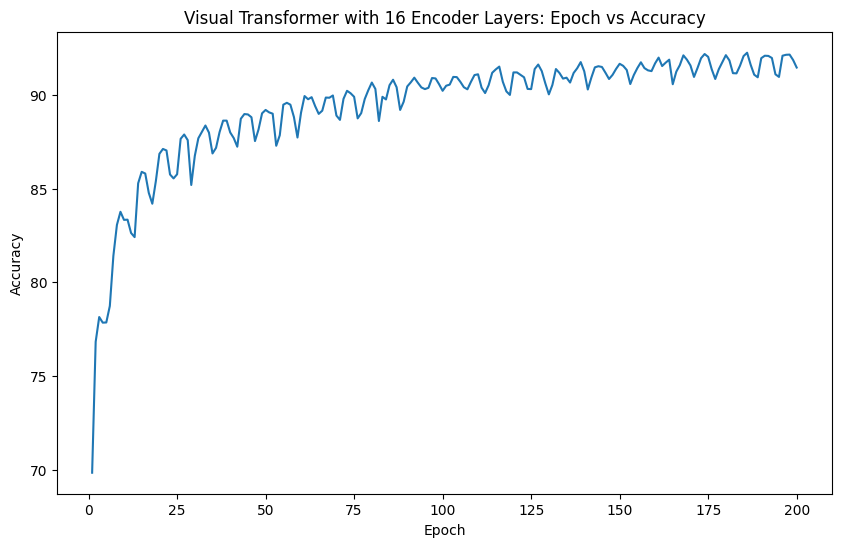

In [5]:
from matplotlib import pyplot as plt

print(accuracies)
epochs = list(range(1, len(accuracies) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, linestyle='-')
plt.title('Visual Transformer with 16 Encoder Layers: Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Final Accuracy: 92.24%
#### Training Time: 8:24:16.513640